In [111]:
# Import Library 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

In [112]:
# Functions Library

# Evaluating function using values from Coefficient array (Setting)
def eval_poly(x, coeffs):
    # coeffs[k] multiplies x^k
    powers = np.vstack([x**k for k in range(len(coeffs))])  # shape (K, N)
    return (coeffs[:, None] * powers).sum(axis=0)

# Formatting + Threshholding Condition
def format_poly(coeffs, var="x", thresh=1e-10):
    terms = []
    for k, c in enumerate(coeffs):
        if abs(c) < thresh:
            continue
        if k == 0:
            terms.append(f"{c:+.5g}")
        elif k == 1:
            terms.append(f"{c:+.5g}·{var}")
        else:
            terms.append(f"{c:+.5g}·{var}^{k}")
    return " ".join(terms) if terms else "0"

def compute_aic_bic(y_true, y_pred, num_params):
    n = len(y_true)
    rss = np.sum((y_true - y_pred)**2)
    aic = 2*num_params + n*np.log(rss/n)
    bic = num_params*np.log(n) + n*np.log(rss/n)
    return aic, bic

def stls_sindy(Theta, y, threshold=0.1, max_iter=10):
    
    w_sparse, residuals, rank, s = np.linalg.lstsq(Theta, y, rcond=None)    #Initial OLS fit

    # STLS!!
    for iteration in range(max_iter):                      # Iterate Up to the max # of DEGREE ex)10 of the polynomial library
        small_idx = np.abs(w_sparse) < threshold           # Set TRUE index for the coefficients -> less than the threshold
        w_sparse[small_idx] = 0.0                          # Set them to zero (idx True -> set to zero)

        # Refit OLS with remainding active terms    
        big_idx = ~small_idx                               # The leftover index (Larger than the threshold survive) -> Flip the boolean now we look at the Big coeffs' index

        w_temp, _, _, _ = np.linalg.lstsq(Theta[:, big_idx], y, rcond=None)      #Iteration of OLS with updated w

        w_sparse[big_idx] = w_temp                         # Update the coefficient vector w

        # Stop condition (Check all the coeff larger than the threshold)
        if np.all((np.abs(w_sparse) > threshold) == big_idx):
            break

    return w_sparse


    

In [113]:
    # Setting for the model
    
    N = 200                    # number of samples
    X_MIN, X_MAX = -1.0, 1.0   # sampling range for x
    DEGREE = 10                # full polynomial library up to power DEGREE
    NOISE_FRAC = 0.05          # noise level as fraction of std(y_true)
    TRUE_COEFFS = np.array([3.0, 0.0, -3.0, 0.0, 0.0, 1.0]) # tested model

In [114]:
# generating coordinates 

x = np.linspace(X_MIN, X_MAX, N)
y_true = eval_poly(x, TRUE_COEFFS)

# Add Gaussian noise to y

y = y_true + NOISE_FRAC * np.std(y_true) * np.random.randn(N) #normaly distributed error

In [115]:
# Variables in Theta (Library)

Theta = np.vander(x, N=DEGREE+1, increasing=True) # shape (N, DEGREE+1)

In [116]:
# OLS to minimize error

w_hat, residuals, rank, s = np.linalg.lstsq(Theta, y, rcond=None)

# Computing y_hat = Theta(Library)*Xi(coefficients)_hat (since )

y_hat = Theta @ w_hat

In [137]:
# STLS OLS

# Normalize Therta to 2-norm : Make Theta (Library comparable)
col_norms = np.linalg.norm(Theta, axis=0) + 1e-12
Theta_n = Theta / col_norms

# Threshold - hyperparameter tuning using AIC/BIC

taus = np.logspace(-4, 0, 30)
aic_list, bic_list, models = [], [], []

# Computer AIC/BIC list for each tau 
for tau in taus:
    w_tau = stls_sindy(Theta_n, y, threshold=tau, max_iter=10)
    y_hat = Theta_n @ w_tau
    k = np.count_nonzero(np.abs(w_tau) > 0)
    aic, bic = compute_aic_bic(y, y_hat, k)
    aic_list.append(aic) 
    bic_list.append(bic)
    models.append(w_tau)

tau_aic = taus[np.argmin(aic_list)]
tau_bic = taus[np.argmin(bic_list)]
w_aic = models[np.argmin(aic_list)] / col_norms  # (y = theta_n * w_n = theta * (w_n/col_norms))
w_bic = models[np.argmin(bic_list)] / col_norms  # Therefore, w = w_n/ col_norms

print("Opt_tau_aic: ", tau_aic)
print("Opt_tau_bic: ", tau_bic)

threshold = 1.0
w_stls = stls_sindy(Theta, y, threshold=threshold, max_iter=10)
y_stls = Theta @ w_stls

# printing the discovered polynomial 

print("True polynomial:      y(x) =", format_poly(TRUE_COEFFS))
print("Estimated polynomial: y(x) =", format_poly(w_hat))

print("")

print(f"STLS polynomial (thr={threshold:+.5g}): y(x) =", format_poly(w_stls))
print(f"STLS (AIC-opt, tau={tau_aic:.2e}): y(x) =", format_poly(w_aic))
print(f"STLS (BIC-opt, tau={tau_bic:.2e}): y(x) =", format_poly(w_bic))


Opt_tau_aic:  0.05736152510448681
Opt_tau_bic:  0.05736152510448681
True polynomial:      y(x) = +3 -3·x^2 +1·x^5
Estimated polynomial: y(x) = +2.9932 -0.065312·x -3.0218·x^2 +0.49034·x^3 -0.54767·x^4 -0.010929·x^5 +3.3015·x^6 +0.77464·x^7 -5.1908·x^8 -0.18617·x^9 +2.4945·x^10

STLS polynomial (thr=+1): y(x) = +2.9947 -3.0929·x^2 +1.7918·x^6 -3.4729·x^8 +1.806·x^10
STLS (AIC-opt, tau=5.74e-02): y(x) = +2.9932 -0.065087·x -3.0218·x^2 +0.48735·x^3 -0.54767·x^4 +3.3015·x^6 +0.75981·x^7 -5.1908·x^8 -0.17945·x^9 +2.4945·x^10
STLS (BIC-opt, tau=5.74e-02): y(x) = +2.9932 -0.065087·x -3.0218·x^2 +0.48735·x^3 -0.54767·x^4 +3.3015·x^6 +0.75981·x^7 -5.1908·x^8 -0.17945·x^9 +2.4945·x^10


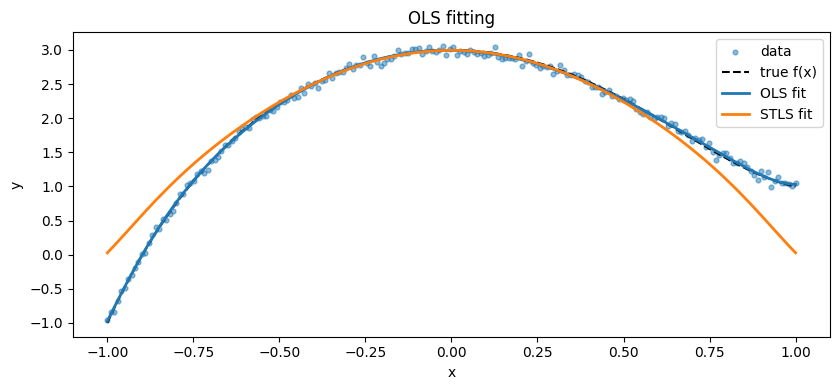

In [118]:
# OLS Results 
# Figure 1 - OLS fit curve 

plt.figure(figsize=(8.5, 4))
plt.scatter(x, y, s=12, alpha=0.5, label="data")
plt.plot(x, y_true, "k--", label="true f(x)")
plt.plot(x, y_hat, label="OLS fit", linewidth=2)
plt.plot(x, y_stls, label="OLS fit", linewidth=2)
plt.xlabel("x"); plt.ylabel("y")
plt.title("OLS fitting")
plt.legend()
plt.tight_layout()
plt.show()


In [119]:
# Ridge Regularization (L2)

# AIC, BIC optimised lambda 

lambdas = np.logspace(-6, 1, 30)
aic_list, bic_list = [], []

for lam in lambdas:
    w_r = np.linalg.solve(Theta.T@Theta + lam*np.eye(Theta.shape[1]), Theta.T@y)
    y_r = Theta @ w_r
    k = np.sum(np.abs(w_r) > 1e-8)          # number of active coefficients
    aic, bic = compute_aic_bic(y_true, y_r, k)
    aic_list.append(aic)
    bic_list.append(bic)

lam_aic = lambdas[np.argmin(aic_list)]
lam_bic = lambdas[np.argmin(bic_list)]

print("Opt_lam_aic: ", lam_aic)
print("Opt_lam_bic: ", lam_bic)

lambda_ridge = lam_bic        #Tuning parameter 

# Ridge Regularisation fit (From derived w_MAP)

I = np.eye(Theta.shape[1])
w_ridge = np.linalg.solve(Theta.T @ Theta + lambda_ridge * I, Theta.T @ y)
y_ridge = Theta @ w_ridge

print("Ridge polynomial: y(x) =", format_poly(w_ridge))


Opt_lam_aic:  0.004175318936560405
Opt_lam_bic:  0.004175318936560405
Ridge polynomial: y(x) = +2.9896 -0.058625·x -3.0236·x^2 +0.39594·x^3 +0.18847·x^4 +0.35735·x^5 -0.074232·x^6 +0.24543·x^7 -0.2243·x^8 +0.064952·x^9 +0.15627·x^10


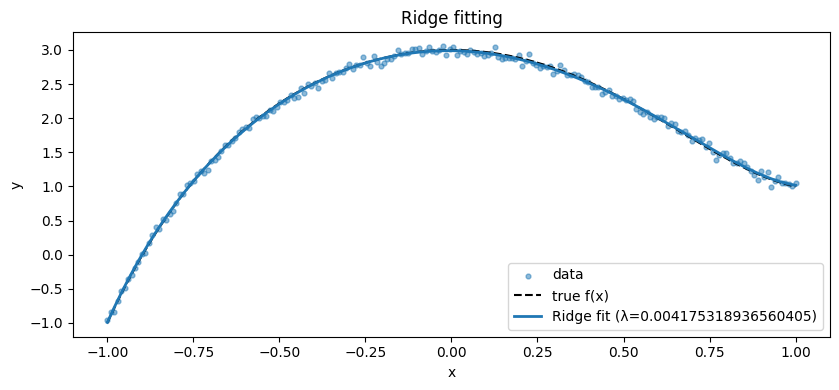

In [120]:
# Figure 2 - Ridge Regression Fit curve 

plt.figure(figsize=(8.5, 4))
plt.scatter(x, y, s=12, alpha=0.5, label="data")
plt.plot(x, y_true, "k--", label="true f(x)")
plt.plot(x, y_ridge, label=f"Ridge fit (λ={lambda_ridge})", linewidth=2)
plt.xlabel("x"); plt.ylabel("y")
plt.title("Ridge fitting")
plt.legend()
plt.tight_layout()
plt.show()


In [121]:
# Lasso regularaisation (L1)

lambdas = np.logspace(-6, 1, 30)     # range of alpha values to test
aic_list, bic_list = [], []

for lam in lambdas:
    lasso = Lasso(alpha=lam, fit_intercept=False, max_iter=10000)
    lasso.fit(Theta, y)
    w_r = lasso.coef_
    y_r = Theta @ w_r

    k = np.sum(np.abs(w_r) > 1e-8)    # number of active (nonzero) coefficients
    aic, bic = compute_aic_bic(y_true=y, y_pred=y_r, num_params=k)
    
    aic_list.append(aic)
    bic_list.append(bic)

# Optimal lambdas
lam_aic = lambdas[np.argmin(aic_list)]
lam_bic = lambdas[np.argmin(bic_list)]

print("Opt_lam_aic:", lam_aic)
print("Opt_lam_bic:", lam_bic)

alpha_lasso = lam_bic   # larger alpha -> more sparse

# Lasso Fitting

lasso = Lasso(alpha=alpha_lasso, fit_intercept=False, max_iter=10000)
lasso.fit(Theta, y)
w_lasso = lasso.coef_
y_lasso = Theta @ w_lasso

print(f"Lasso polynomial (alpha={alpha_lasso}): y(x) = {format_poly(w_lasso)}")


Opt_lam_aic: 0.0007880462815669912
Opt_lam_bic: 0.0007880462815669912
Lasso polynomial (alpha=0.0007880462815669912): y(x) = +2.9835 -2.9586·x^2 +0.060857·x^3 +0.92268·x^5


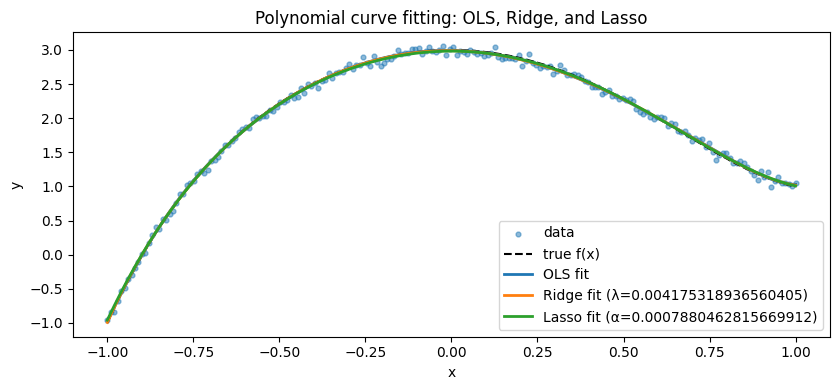

In [122]:
# Lasso Plot comparison

plt.figure(figsize=(8.5, 4))
plt.scatter(x, y, s=12, alpha=0.5, label="data")
plt.plot(x, y_true, "k--", label="true f(x)")
plt.plot(x, y_hat,   label="OLS fit", linewidth=2)
plt.plot(x, y_ridge, label=f"Ridge fit (λ={lambda_ridge})", linewidth=2)
plt.plot(x, y_lasso, label=f"Lasso fit (α={alpha_lasso})", linewidth=2)
plt.xlabel("x"); plt.ylabel("y")
plt.title("Polynomial curve fitting: OLS, Ridge, and Lasso")
plt.legend()
plt.tight_layout()
plt.show()


OLS   RMSE=1.2760e-02, MAE=1.0750e-02
Ridge RMSE=1.1542e-02, MAE=1.0087e-02
Lasso RMSE=1.3782e-02, MAE=1.2218e-02


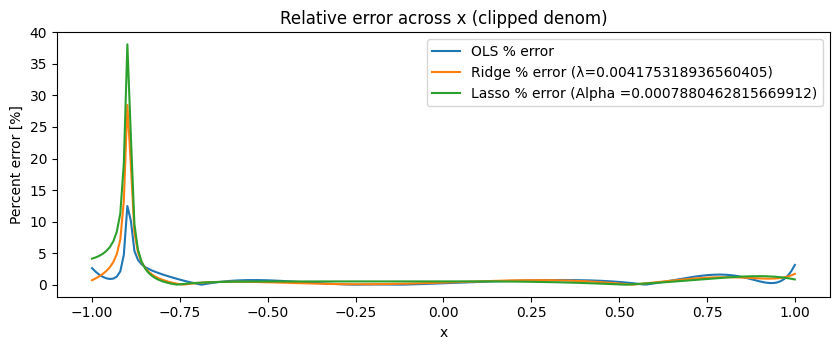

In [123]:
# Error comparison 

# RMSE, MAE comparison
def rmse(a, b): return np.sqrt(np.mean((a - b)**2))
def mae(a, b):  return np.mean(np.abs(a - b))

err_ols_rmse = rmse(y_hat, y_true)
err_ridge_rmse = rmse(y_ridge, y_true)
err_lasso_rmse = rmse(y_lasso, y_true)

err_ols_mae = mae(y_hat, y_true)
err_ridge_mae = mae(y_ridge, y_true)
err_lasso_mae = mae(y_lasso, y_true)

print(f"OLS   RMSE={err_ols_rmse:.4e}, MAE={err_ols_mae:.4e}")
print(f"Ridge RMSE={err_ridge_rmse:.4e}, MAE={err_ridge_mae:.4e}")
print(f"Lasso RMSE={rmse(y_lasso, y_true):.4e}, MAE={err_lasso_mae:.4e}")

# percentage error comparison plot
eps = 0.05 * np.std(y_true)
denom = np.clip(np.abs(y_true), eps, None)
err_ols_pct   = 100 * np.abs(y_hat   - y_true) / denom
err_ridge_pct = 100 * np.abs(y_ridge - y_true) / denom
err_lasso_pct = 100 * np.abs(y_lasso - y_true) / denom


plt.figure(figsize=(8.5, 3.6))
plt.plot(x, err_ols_pct,   label="OLS % error")
plt.plot(x, err_ridge_pct, label=f"Ridge % error (λ={lambda_ridge})")
plt.plot(x, err_lasso_pct, label=f"Lasso % error (Alpha ={alpha_lasso})")
plt.xlabel("x"); plt.ylabel("Percent error [%]")
plt.title("Relative error across x (clipped denom)")
plt.legend()
plt.tight_layout()
plt.show()
